# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install timezonefinder

  Using cached https://files.pythonhosted.org/packages/51/c0/d5dab6191ee631f811a6bfc710552f500eb2bb8b7751b72051aaa1692582/timezonefinder-4.0.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2f/f7/b4aa02cdd3ee7ebba375969d77c00826aa15c5db84247d23c89522dccbfa/importlib_resources-1.0.2-py2.py3-none-any.whl


In [4]:
from timezonefinder import TimezoneFinder
import pytz

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Collect Weather Data

### Import Airport code match data (for collecting weather data)

In [4]:
airport_match = pd.read_csv('Airport_Code_Match.csv')

In [5]:
airport_match = airport_match[airport_match['AIRPORT_IS_LATEST']==1]

In [6]:
airport_latlon = pd.merge(unique_airport,airport_match,left_on='ORIGIN_AIRPORT_ID',
                          right_on='AIRPORT_ID',how='inner')

In [7]:
airport_loc = airport_latlon[['ORIGIN_AIRPORT_ID','ORIGIN','LATITUDE','LONGITUDE']]

### API from WWO

In [9]:
import requests

In [10]:
def get_request(q,date,end_date):
    
    parameters = {'q': q, 
                  'date': date, # format '2018-01-01'
                  'enddate':end_date,
                  'tp':'1',
                  'includelocation':'yes',
                  'format':'json',
                  'key':'22528998d4d548d2ba0102133192004'}

    response = requests.get("https://api.worldweatheronline.com/premium/v1/past-weather.ashx", params=parameters)
    
    data = response.json()
    
    if response.status_code != 200:
        raise Exception('status code is not 200')
    
    return data

In [11]:
date_range = pd.DataFrame(
            {'start_date':['2018-01-01','2018-02-01','2018-03-01','2018-04-01','2018-05-01',
                           '2018-06-01','2018-07-01','2018-08-01','2018-09-01','2018-10-01',
                            '2018-11-01','2018-12-01'],
             'end_date':['2018-01-31','2018-02-28','2018-03-31','2018-04-30','2018-05-31',
                           '2018-06-30','2018-07-31','2018-08-31','2018-09-30','2018-10-31',
                            '2018-11-30','2018-12-31']})

In [12]:
def init_df():
    
    cols = ['Airport_id', 'Airport_name', 'Date', 'DewPointC', 'DewPointF',
       'FeelsLikeC', 'FeelsLikeF', 'HeatIndexC', 'HeatIndexF', 'WindChillC',
       'WindChillF', 'WindGustKmph', 'WindGustMiles', 'cloudcover', 'humidity',
       'precipMM', 'pressure', 'tempC', 'tempF', 'time', 'uvIndex',
       'visibility', 'weatherCode', 'weatherDesc', 'weatherIconUrl',
       'winddir16Point', 'winddirDegree', 'windspeedKmph', 'windspeedMiles']
    
    init_df = pd.DataFrame(columns=cols)
    return init_df

In [13]:
def data_to_df(data,airport_id,airport_name):

    rows = []

    for date in data['data']['weather']:
        hour_data = date['hourly']
        day = date['date']

        for hour in hour_data:
            hour['Date'] = day
            hour['Airport_id'] = airport_id
            hour['Airport_name'] = airport_name
            rows.append(hour)

    df = pd.DataFrame(rows)
    
    return df

### Weather Batch Schedule

- Batch 1: [0:20], from EWR to SLC
- Batch 2: [20:60], from RDU to BZN
- Batch 3: [60:100], from EUG to BLI
- Batch 4: [100:149], from SBA to DAY
- Batch 5: [149:195], from ATW to RST
- Batch 6: [195:240], from BRO to JLN
- Batch 7: [240:285], from CMI to TWF
- Batch 8: [285:330], from MBS to ADK

In [87]:
# initialise an empty DataFrame
full_df = init_df()

for index, row in airport_loc.iloc[330:,:].iterrows():
    coordinate = str(row['LATITUDE']) + ',' + str(row['LONGITUDE'])
    airport_id = row['ORIGIN_AIRPORT_ID']
    airport_name = row['ORIGIN']
    print(index)
    
    for index, row in date_range.iterrows():
        data = get_request(q=coordinate,date=row['start_date'],end_date=row['end_date'])
        df = data_to_df(data=data,airport_id = airport_id,airport_name = airport_name)
        full_df = full_df.append(df,ignore_index=True)

330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357


In [93]:
len(full_df['Airport_name'].value_counts())

28

In [89]:
full_df.shape

(245280, 29)

In [91]:
weather_batch9 = full_df.copy()

In [92]:
weather_batch9.to_csv('weather_batch9.csv')

### Combine all weather data

In [3]:
w_01 = pd.read_csv('weather_batch1.csv')
w_02 = pd.read_csv('weather_batch2.csv')
w_03 = pd.read_csv('weather_batch3.csv')
w_04 = pd.read_csv('weather_batch4.csv')
w_05 = pd.read_csv('weather_batch5.csv')
w_06 = pd.read_csv('weather_batch6.csv')
w_07 = pd.read_csv('weather_batch7.csv')
w_08 = pd.read_csv('weather_batch8.csv')
w_09 = pd.read_csv('weather_batch9.csv')

In [4]:
all_weather_data = w_01.append([w_02,w_03,w_04,w_05,w_06,w_07,w_08,w_09])

In [5]:
all_weather_data.shape

(3136080, 30)

In [41]:
# get the description out
all_weather_data['weatherDesc_new'] = all_weather_data['weatherDesc'].apply(lambda x
                                                                            :x.split("'")[-2])

In [4]:
all_weather_data.head()

,Airport_id,Airport_name,Date,DewPointC,DewPointF,FeelsLikeC,FeelsLikeF,HeatIndexC,HeatIndexF,WindChillC,WindChillF,WindGustKmph,WindGustMiles,cloudcover,humidity,precipMM,pressure,tempC,tempF,time,uvIndex,visibility,weatherCode,weatherDesc,weatherIconUrl,winddir16Point,winddirDegree,windspeedKmph,windspeedMiles,weatherDesc_new
0,11618,EWR,2018-01-01,-17,1,-20,-5,-12,10,-20,-5,24,15,4,65,0.0,1028,-12,10,0,0,10,113,[{'value': 'Clear'}],[{'value': 'http://cdn.worldweatheronline.net/...,NW,324,21,13,Clear
1,11618,EWR,2018-01-01,-17,1,-20,-5,-12,11,-20,-5,24,15,4,65,0.0,1028,-12,10,100,0,10,113,[{'value': 'Clear'}],[{'value': 'http://cdn.worldweatheronline.net/...,NW,323,21,13,Clear
2,11618,EWR,2018-01-01,-17,1,-20,-5,-12,11,-20,-5,25,15,3,65,0.0,1028,-12,10,200,0,10,113,[{'value': 'Clear'}],[{'value': 'http://cdn.worldweatheronline.net/...,NW,322,21,13,Clear
3,11618,EWR,2018-01-01,-17,1,-20,-5,-12,11,-20,-5,25,16,3,65,0.0,1028,-12,10,300,0,10,113,[{'value': 'Clear'}],[{'value': 'http://cdn.worldweatheronline.net/...,NW,322,21,13,Clear
4,11618,EWR,2018-01-01,-17,1,-20,-5,-12,10,-20,-5,24,15,3,65,0.0,1029,-13,9,400,0,10,113,[{'value': 'Clear'}],[{'value': 'http://cdn.worldweatheronline.net/...,NW,317,20,13,Clear


In [5]:
all_weather_data.columns

Index(['Airport_id', 'Airport_name', 'Date', 'DewPointC', 'DewPointF',
       'FeelsLikeC', 'FeelsLikeF', 'HeatIndexC', 'HeatIndexF', 'WindChillC',
       'WindChillF', 'WindGustKmph', 'WindGustMiles', 'cloudcover', 'humidity',
       'precipMM', 'pressure', 'tempC', 'tempF', 'time', 'uvIndex',
       'visibility', 'weatherCode', 'weatherDesc', 'weatherIconUrl',
       'winddir16Point', 'winddirDegree', 'windspeedKmph', 'windspeedMiles',
       'weatherDesc_new'],
      dtype='object')

In [6]:
all_weather_data['Datetime'] = pd.to_datetime(all_weather_data['Date'])

In [7]:
all_weather_data['Hour'] = all_weather_data['time'].apply(lambda x:int(x/100))

### Drop unwanted columns from the weather dataset

In [8]:
all_weather_data = all_weather_data.drop(['Airport_id','Date','DewPointF','FeelsLikeF',
                                          'HeatIndexF','WindChillF','WindGustMiles','tempF',
                                          'time', 'weatherCode', 'weatherDesc', 'weatherIconUrl',
                                          'windspeedMiles'],axis=1)

In [9]:
all_weather_data.columns

Index(['Airport_name', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'uvIndex', 'visibility', 'winddir16Point', 'winddirDegree',
       'windspeedKmph', 'weatherDesc_new', 'Datetime', 'Hour'],
      dtype='object')

In [18]:
all_weather_data.to_csv('all_weather_data.csv')

In [34]:
all_weather_data = pd.read_csv('all_weather_data.csv',index_col = 0)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [35]:
all_weather_data.shape

(3136080, 19)

In [38]:
len(all_weather_data['Airport_name'].drop_duplicates())

358

In [93]:
all_weather_data['Datetime'] = pd.to_datetime(all_weather_data['Datetime'])

# Collect flight on-time data

In [28]:
d_01 = pd.read_csv('01_2018.csv')
d_02 = pd.read_csv('02_2018.csv')
d_03 = pd.read_csv('03_2018.csv')
d_04 = pd.read_csv('04_2018.csv')
d_05 = pd.read_csv('05_2018.csv')
d_06 = pd.read_csv('06_2018.csv')
d_07 = pd.read_csv('07_2018.csv')
d_08 = pd.read_csv('08_2018.csv')
d_09 = pd.read_csv('09_2018.csv')
d_10 = pd.read_csv('10_2018.csv')
d_11 = pd.read_csv('11_2018.csv')
d_12 = pd.read_csv('12_2018.csv')

In [29]:
all_data = d_01.append([d_02,d_03,d_04,d_05,d_06,d_07,d_08,d_09,d_10,d_11,d_12])

In [30]:
all_data.shape

(7213446, 28)

In [31]:
all_data.to_csv('all_data.csv')

In [2]:
all_data = pd.read_csv('all_data.csv',index_col = 0)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
major_apt = ['ATL','BOS','BWI','CLT','DCA','DEN','DFW','DTW','EWR','FLL','HNL','IAD',
             'IAH','JFK','LAS','LAX','LGA','MCO','MDW','MEM','MIA','MSP','ORD','PHL',
             'PHX','PDX','SAN','SEA','SFO','SLC','TPA','LGB','OAK','SNA']

In [6]:
major = all_data[all_data['ORIGIN'].isin(major_apt)]

In [7]:
major.shape

(4787995, 28)

In [8]:
all_data.shape

(7213446, 28)

In [4]:
all_data.head()

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,...,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,Unnamed: 27
0,2018-01-01,UA,N434UA,2429,11618,EWR,"Newark, NJ",11292,DEN,"Denver, CO",...,1722.0,-23.0,0.0,NaN,0.0,268.0,250.0,225.0,1605.0,NaN
1,2018-01-01,UA,N76528,2427,12889,LAS,"Las Vegas, NV",14771,SFO,"San Francisco, CA",...,1230.0,-24.0,0.0,NaN,0.0,99.0,83.0,65.0,414.0,NaN
2,2018-01-01,UA,N27205,2426,14908,SNA,"Santa Ana, CA",11292,DEN,"Denver, CO",...,1636.0,-13.0,0.0,NaN,0.0,134.0,126.0,106.0,846.0,NaN
3,2018-01-01,UA,N14214,2425,14635,RSW,"Fort Myers, FL",13930,ORD,"Chicago, IL",...,1754.0,-2.0,0.0,NaN,0.0,190.0,182.0,157.0,1120.0,NaN
4,2018-01-01,UA,N404UA,2424,13930,ORD,"Chicago, IL",10257,ALB,"Albany, NY",...,936.0,14.0,0.0,NaN,0.0,112.0,106.0,83.0,723.0,NaN


In [11]:
all_data.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
       'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
       'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'Unnamed: 27'],
      dtype='object')

In [6]:
unique_airport = all_data[['ORIGIN_AIRPORT_ID', 'ORIGIN']].drop_duplicates()

In [12]:
all_data['FL_DATE'] = pd.to_datetime(all_data['FL_DATE'])

In [14]:
all_data['Month'] = all_data['FL_DATE'].dt.month

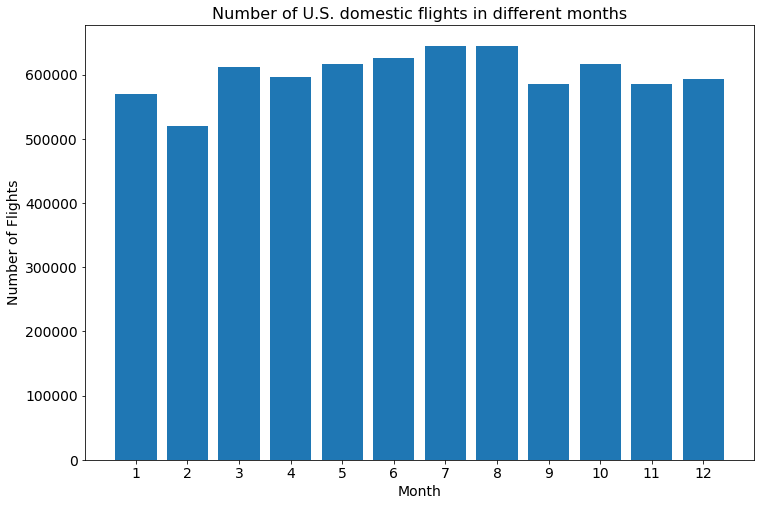

In [33]:
plt.figure(figsize=(12,8))
plt.bar(all_data['Month'].value_counts().index,all_data['Month'].value_counts().values)
plt.xticks(np.arange(1,13),size=14)
plt.yticks(size=14)
plt.xlabel('Month',size=14)
plt.ylabel('Number of Flights',size=14)
plt.title('Number of U.S. domestic flights in different months',size=16)
plt.show()

In [39]:
def binarise(data):
    if data <= 15:
        return 0
    else:
        return 1
    
all_data['DEP_DELAY_BI'] = all_data['DEP_DELAY'].apply(binarise)

In [40]:
all_data['DEP_DELAY_BI'].value_counts()

0    5833390
1    1380056
Name: DEP_DELAY_BI, dtype: int64

# Collect Aircraft Info

In [37]:
master = pd.read_csv('MASTER.txt')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
aircraft = pd.read_csv('ACFTREF.txt')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
engine = pd.read_csv('ENGINE.txt')

In [40]:
# there is one na value in the tail num
unique_n = all_data[['TAIL_NUM']].drop_duplicates().dropna()
# get the n number except the N
unique_n['N_short'] = unique_n['TAIL_NUM'].apply(lambda x : x[1:])

NameError: name 'all_data' is not defined

In [16]:
# merge with the master file
n_master = pd.merge(unique_n,master[['N-NUMBER','MFR MDL CODE','ENG MFR MDL','YEAR MFR']],
                    left_on='N_short',right_on='N-NUMBER',how='inner')

In [17]:
n_aircraft = pd.merge(n_master,aircraft[['CODE','MFR','MODEL','NO-ENG']],
                      left_on='MFR MDL CODE',right_on='CODE',how='inner')
engine['CODE_str'] = engine['CODE'].apply(str)

In [18]:
acft_info = pd.merge(n_aircraft,engine[['CODE_str','MFR','MODEL']],
                     left_on='ENG MFR MDL',right_on='CODE_str',how='inner')

In [6]:
acft_info = acft_info[['TAIL_NUM','YEAR MFR','MFR_x','MODEL_x']]

In [4]:
acft_info.head()

,TAIL_NUM,YEAR MFR,MFR_x,MODEL_x
0,N434UA,1996,AIRBUS INDUSTRIE,A320-232
1,N404UA,1993,AIRBUS INDUSTRIE,A320-232
2,N487UA,2002,AIRBUS INDUSTRIE,A320-232
3,N416UA,1994,AIRBUS INDUSTRIE,A320-232
4,N405UA,1993,AIRBUS INDUSTRIE,A320-232


In [8]:
acft_info.to_csv('acft_info.csv')

In [3]:
acft_info = pd.read_csv('acft_info.csv',index_col = 0)

## Aircraft info from BTS database

In [5]:
acft_info2 = pd.read_csv('ACF_info2.csv',encoding = "ISO-8859-1")

In [6]:
acft_info2 = acft_info2[['MANUFACTURE_YEAR','TAIL_NUMBER',
                         'MANUFACTURER','MODEL']]

In [7]:
acft_info2.head()

,MANUFACTURE_YEAR,TAIL_NUMBER,MANUFACTURER,MODEL
0,1990,N801TJ,Boeing,737-4B7
1,1990,N802TJ,Boeing,737-4B7
2,1993,N803TJ,Boeing,737-45D
3,1989,N804TJ,Boeing,737-401
4,1989,N418US,Boeing,737-401


#### Drop duplicates values for tail_number

In [8]:
acft_info2 = acft_info2.drop([490])

In [9]:
acft_info2 = acft_info2.drop([622])

In [10]:
acft_info2 = acft_info2.drop([626])

In [11]:
acft_info2 = acft_info2.drop(range(5358,5367))

# Preprocessing

## Extract major airports flights

In [15]:
major_apt = ['ATL','BOS','BWI','CLT','DCA','DEN','DFW','DTW','EWR','FLL','HNL','IAD',
             'IAH','JFK','LAS','LAX','LGA','MCO','MDW','MEM','MIA','MSP','ORD','PHL',
             'PHX','PDX','SAN','SEA','SFO','SLC','TPA','LGB','OAK','SNA']

In [9]:
major_flights = all_data[(all_data['ORIGIN'].isin(major_apt)) | 
                         (all_data['DEST'].isin(major_apt))]

In [17]:
print('The major airports account for ' + 
      str(round(major_flights.shape[0]/all_data.shape[0]*100,2)) + 
     '% of flights')

The major airports account for 94.88% of flights


In [18]:
major_flights.to_csv('major_flights.csv') 

In [41]:
mj_flt = pd.read_csv('major_flights.csv',index_col = 0)
mj_flt.reset_index(drop=True,inplace=True)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Extracting datetime related values

In [5]:
mj_flt.head()

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,Unnamed: 27
0,2018-01-01,UA,N434UA,2429,11618,EWR,"Newark, NJ",11292,DEN,"Denver, CO",1517,1512.0,-5.0,15.0,1527.0,1712.0,10.0,1745,1722.0,-23.0,0.0,NaN,0.0,268.0,250.0,225.0,1605.0,NaN
1,2018-01-01,UA,N76528,2427,12889,LAS,"Las Vegas, NV",14771,SFO,"San Francisco, CA",1115,1107.0,-8.0,11.0,1118.0,1223.0,7.0,1254,1230.0,-24.0,0.0,NaN,0.0,99.0,83.0,65.0,414.0,NaN
2,2018-01-01,UA,N27205,2426,14908,SNA,"Santa Ana, CA",11292,DEN,"Denver, CO",1335,1330.0,-5.0,15.0,1345.0,1631.0,5.0,1649,1636.0,-13.0,0.0,NaN,0.0,134.0,126.0,106.0,846.0,NaN
3,2018-01-01,UA,N14214,2425,14635,RSW,"Fort Myers, FL",13930,ORD,"Chicago, IL",1546,1552.0,6.0,19.0,1611.0,1748.0,6.0,1756,1754.0,-2.0,0.0,NaN,0.0,190.0,182.0,157.0,1120.0,NaN
4,2018-01-01,UA,N404UA,2424,13930,ORD,"Chicago, IL",10257,ALB,"Albany, NY",630,650.0,20.0,13.0,703.0,926.0,10.0,922,936.0,14.0,0.0,NaN,0.0,112.0,106.0,83.0,723.0,NaN


In [42]:
# dropping those days that are transiting to and from DST for simplicity
indexNames = mj_flt[(mj_flt['FL_DATE'] == '2018-03-10') |
                (mj_flt['FL_DATE'] == '2018-03-11') |
                (mj_flt['FL_DATE'] == '2018-11-03') |
                (mj_flt['FL_DATE'] == '2018-11-04')].index
mj_flt.drop(indexNames , inplace=True)

## Clean the missing value for tail_num (cancelled flights)

In [43]:
mj_flt.dropna(subset=['TAIL_NUM'],inplace=True)

In [44]:
# Drop those cancelled flights
mj_flt = mj_flt.dropna(subset=['DEP_TIME'])

In [45]:
# Drop those diverted flights
mj_flt = mj_flt.dropna(subset=['ARR_TIME'])
mj_flt = mj_flt[mj_flt['DIVERTED'] == 0]

In [46]:
mj_flt.shape

(6646329, 28)

In [7]:
def pad_time(dataset,column='DEP_TIME'):
    dataset[column] = dataset[column].apply(lambda x: str(int(x)).zfill(4))
    dataset[column] = dataset[column].replace({'2400':'0000'})

def round_to_hour(dataset,column='DEP_TIME'):
    dataset[column+'_Hour'] = pd.to_datetime(dataset[column],
                                              format='%H%M').dt.round('H').dt.hour

def round_to_30min(dataset,column='DEP_TIME'):
    dataset[column+'_HfHr'] = pd.to_datetime(dataset[column],format='%H%M').dt.round('30min')

In [11]:
pad_time(mj_flt,column='DEP_TIME')
pad_time(mj_flt,column='ARR_TIME')
pad_time(mj_flt,column='CRS_DEP_TIME')
pad_time(mj_flt,column='CRS_ARR_TIME')

## About departure time

In [12]:
# create a datetime column for the scheduled departure time
mj_flt['CRS_DEP_DT'] = mj_flt['FL_DATE'] + ' ' + mj_flt['CRS_DEP_TIME']
mj_flt['CRS_DEP_DT'] = pd.to_datetime(mj_flt['CRS_DEP_DT'] ,format='%Y-%m-%d %H%M')

In [13]:
# convert the delay time to a timedelta column
mj_flt['DEP_DELAY_TD'] = pd.to_timedelta(mj_flt['DEP_DELAY'],unit='min')
mj_flt['CRS_ELAPSED_TD'] = pd.to_timedelta(mj_flt['CRS_ELAPSED_TIME'],unit='min')

In [14]:
# create the actual departure time column
mj_flt['DEP_DT'] = mj_flt['CRS_DEP_DT'] + mj_flt['DEP_DELAY_TD']

In [15]:
mj_flt['Weekday'] = mj_flt['CRS_DEP_DT'].dt.dayofweek
mj_flt['Month'] = mj_flt['CRS_DEP_DT'].dt.month
mj_flt['Day'] = mj_flt['CRS_DEP_DT'].dt.day
mj_flt['Week_no'] = mj_flt['CRS_DEP_DT'].dt.weekofyear

## About arrival time

### Find timezone for each airport

In [16]:
airport_cor = pd.read_csv('Airport_cor.csv')
airport_cor = airport_cor[airport_cor['AIRPORT_IS_LATEST']==1]

In [17]:
from timezonefinder import TimezoneFinder

tf = TimezoneFinder()

airport_cor = airport_cor.dropna(subset=['LONGITUDE'])

tz_list = []
for index, row in airport_cor.iterrows():
    tz_list.append(tf.timezone_at(lng=row['LONGITUDE'],lat=row['LATITUDE']))

airport_cor['tz'] = tz_list

airport_cor['tz'][108] = 'America/Anchorage'
airport_cor['tz'][7776] = 'Asia/Ho_Chi_Minh'

airport_cor = airport_cor[['AIRPORT_ID','tz']]

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
# merge the time zone info with the major flight
mj_flt = pd.merge(mj_flt,airport_cor,left_on='ORIGIN_AIRPORT_ID',right_on='AIRPORT_ID')
mj_flt = pd.merge(mj_flt,airport_cor,left_on='DEST_AIRPORT_ID',right_on='AIRPORT_ID')
mj_flt.rename({'tz_x':'ORI_TZ','tz_y':'DEST_TZ'},axis=1,inplace=True)

In [19]:
from datetime import datetime
def is_dst(dt=None, timezone="UTC"):
    if dt is None:
        dt = datetime.utcnow()
    timezone_aware_date = pytz.timezone(timezone).localize(dt, is_dst=None)
    return timezone_aware_date.tzinfo._dst.seconds != 0

In [49]:
mj_flt.shape

(6646329, 43)

In [28]:
def get_crs_arr(row):
    dst_flag = is_dst(row['CRS_DEP_DT'],row['ORI_TZ'])
    local_tz = pytz.timezone(row['ORI_TZ'])
    utc_time = local_tz.localize(row['CRS_DEP_DT'], is_dst=dst_flag).astimezone(pytz.utc)
    dest_utc = utc_time + row['CRS_ELAPSED_TD']
    dest_local = dest_utc.astimezone(row['DEST_TZ'])
    return dest_local

for i in range(0,6600000,100000):
    print(i)
    mj_flt.loc[i:i+100000,['CRS_ARR_DT']] = mj_flt[i:i+100000].apply(get_crs_arr,axis=1)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000


In [29]:
mj_flt.loc[6500000:6646329,['CRS_ARR_DT']] = mj_flt[6500000:6646329].apply(get_crs_arr,axis=1)

In [20]:
#start = np.array(np.arange(0,6900000,300000))
#end = np.array(np.arange(300000,6900000,300000))
#end = np.append(end,6729517)

In [44]:
"""
tim = []
for (i,j) in zip(start,end):
    for index, row in mj_flt[i:j].iterrows():
        dst_flag = is_dst(row['CRS_DEP_DT'],row['ORI_TZ'])
        local_tz = pytz.timezone(row['ORI_TZ'])
        utc_time = local_tz.localize(row['CRS_DEP_DT'], is_dst=dst_flag).astimezone(pytz.utc)
        dest_utc = utc_time + row['CRS_ELAPSED_TD']
        dest_local = dest_utc.astimezone(row['DEST_TZ']) 
        tim.append(dest_local)

        if index%10000 == 0:
            print(index)
        if index == 906:
            print(dest_local)
"""

"\ntim = []\nfor (i,j) in zip(start,end):\n    for index, row in mj_flt[i:j].iterrows():\n        dst_flag = is_dst(row['CRS_DEP_DT'],row['ORI_TZ'])\n        local_tz = pytz.timezone(row['ORI_TZ'])\n        utc_time = local_tz.localize(row['CRS_DEP_DT'], is_dst=dst_flag).astimezone(pytz.utc)\n        dest_utc = utc_time + row['CRS_ELAPSED_TD']\n        dest_local = dest_utc.astimezone(row['DEST_TZ']) \n        tim.append(dest_local)\n\n        if index%10000 == 0:\n            print(index)\n        if index == 906:\n            print(dest_local)\n"

In [39]:
#pd.DataFrame(tim,columns=['col']).to_csv('tim.csv')

In [22]:
#df = pd.read_csv('tim.csv',index_col = 0)

In [23]:
#mj_flt['CRS_ARR_DT'] = df['col']

In [30]:
mj_flt['CRS_ARR_DT'] = pd.to_datetime(mj_flt['CRS_ARR_DT'].apply(lambda x:str(x)[:-6]))

In [72]:
# calculate nan values for arr_delay
mj_flt.loc[mj_flt['ARR_DELAY'].isnull(),'ARR_DELAY'] = (mj_flt.loc[mj_flt['ARR_DELAY'].isnull(),'ARR_TIME'].apply(int) - 
                                                        mj_flt.loc[mj_flt['ARR_DELAY'].isnull(),'CRS_ARR_TIME'].apply(int))

In [73]:
mj_flt['ARR_DELAY_TD'] = pd.to_timedelta(mj_flt['ARR_DELAY'],unit='min')
mj_flt['ARR_DT'] = mj_flt['CRS_ARR_DT'] + mj_flt['ARR_DELAY_TD']

In [1]:
#round_to_hour(mj_flt_mgwea,column='DEP_TIME')
#round_to_hour(mj_flt_mgwea,column='ARR_TIME')
#round_to_hour(mj_flt_mgwea,column='CRS_DEP_TIME')
#round_to_hour(mj_flt_mgwea,column='CRS_ARR_TIME')

In [32]:
#round_to_30min(mj_flt,column='DEP_TIME')
#round_to_30min(mj_flt,column='ARR_TIME')
#round_to_30min(mj_flt,column='CRS_DEP_TIME')
#round_to_30min(mj_flt,column='CRS_ARR_TIME')

## Merge with aircraft information

In [83]:
mj_flt = pd.merge(mj_flt,acft_info2,left_on='TAIL_NUM',right_on='TAIL_NUMBER',how='left')

In [84]:
mj_flt.shape

(6646329, 47)

In [85]:
mj_flt = pd.merge(mj_flt,acft_info,left_on='TAIL_NUM',right_on='TAIL_NUM',how='left')

In [86]:
mj_flt.shape

(6646329, 50)

In [ ]:
#missing = mj_flt[(mj_flt['MANUFACTURE_YEAR'].isnull())&(mj_flt['YEAR MFR'].isnull())]

In [27]:
#missing.shape

(67467, 44)

67467 rows doesn't have any of the two aircraft information

## Debug the CRS_ARR_TIME problem

In [70]:
mask = (mj_flt['CRS_ARR_TIME'].apply(lambda x:int(x[2:])) != mj_flt['CRS_ARR_DT'].dt.minute)
a = mj_flt[mask][['CRS_ARR_TIME','CRS_ARR_DT','DEST_TZ']]
a.head()

,CRS_ARR_TIME,CRS_ARR_DT,DEST_TZ


In [69]:
def correct_dt(row):
    aa = pd.Timestamp(row['CRS_ARR_DT'].year,
                     row['CRS_ARR_DT'].month,
                     row['CRS_ARR_DT'].day,
                     int(row['CRS_ARR_TIME'][:2]),
                     int(row['CRS_ARR_TIME'][2:]))
    return aa

mj_flt.loc[mask,'CRS_ARR_DT'] = mj_flt.loc[mask].apply(correct_dt,axis=1)

In [28]:
def check_process(crs_dep_dt,ori_tz,crs_elapsed_td,dest_tz):
    dst_flag = is_dst(crs_dep_dt,ori_tz)
    local_tz = pytz.timezone(ori_tz)
    utc_time = local_tz.localize(crs_dep_dt, is_dst=dst_flag).astimezone(pytz.utc)
    dest_utc = utc_time + crs_elapsed_td
    dest_local = dest_utc.astimezone(dest_tz)
    return dest_local

## Drop unwanted columns

In [88]:
mj_flt.drop(['TAXI_OUT','WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
             'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
             'Unnamed: 27','TAIL_NUMBER','AIRPORT_ID_x','AIRPORT_ID_y',
             'ORIGIN_CITY_NAME','DEST_CITY_NAME','CRS_DEP_TIME', 'DEP_TIME',
             'CRS_ARR_TIME','ARR_TIME'],axis=1,inplace=True)

In [89]:
mj_flt.shape

(6646329, 33)

In [94]:
mj_flt.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'DEP_DELAY',
       'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CRS_DEP_DT', 'DEP_DELAY_TD', 'CRS_ELAPSED_TD', 'DEP_DT',
       'Weekday', 'Month', 'Day', 'Week_no', 'ORI_TZ', 'DEST_TZ', 'CRS_ARR_DT',
       'ARR_DELAY_TD', 'ARR_DT', 'MANUFACTURE_YEAR', 'MANUFACTURER', 'MODEL',
       'YEAR MFR', 'MFR_x', 'MODEL_x'],
      dtype='object')

In [91]:
mj_flt.to_csv('ready_data.csv')

In [10]:
mj_flt = pd.read_csv('ready_data.csv',index_col=0)

## Merge with the weather data

In [108]:
mj_flt['DEP_DATE'] = mj_flt['CRS_DEP_DT'].apply(lambda x:x.date())
mj_flt['DEP_HOUR'] = mj_flt['CRS_DEP_DT'].dt.hour
all_weather_data['Datetime'] = all_weather_data['Datetime'].apply(lambda x:x.date())

In [109]:
mj_flt_mgwea = pd.merge(mj_flt,all_weather_data,
                        left_on=['ORIGIN','DEP_DATE','DEP_HOUR'],
                        right_on=['Airport_name','Datetime','Hour'],how='inner')

In [110]:
mj_flt_mgwea.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'DEP_DELAY',
       'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CRS_DEP_DT', 'DEP_DELAY_TD', 'CRS_ELAPSED_TD', 'DEP_DT',
       'Weekday', 'Month', 'Day', 'Week_no', 'ORI_TZ', 'DEST_TZ', 'CRS_ARR_DT',
       'ARR_DELAY_TD', 'ARR_DT', 'MANUFACTURE_YEAR', 'MANUFACTURER', 'MODEL',
       'YEAR MFR', 'MFR_x', 'MODEL_x', 'DEP_DATE', 'DEP_HOUR', 'Airport_name',
       'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph',
       'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'uvIndex',
       'visibility', 'winddir16Point', 'winddirDegree', 'windspeedKmph',
       'weatherDesc_new', 'Datetime', 'Hour'],
      dtype='object')

In [5]:
mj_flt_mgwea.drop(['Datetime', 'Hour','Airport_name','DEP_DATE', 'DEP_HOUR'],axis=1,inplace=True)

## Merge the wide/narrow aircraft column

In [6]:
check_model = pd.read_csv('check_model.csv',index_col = 0)

In [7]:
mj_flt_mgwea = pd.merge(mj_flt_mgwea,check_model,
                         left_on=['MANUFACTURER','MODEL','MFR_x','MODEL_x'],
                         right_on=['MANUFACTURER','MODEL','MFR_x','MODEL_x'],
                         how='left')

In [8]:
mj_flt_mgwea.loc[mj_flt_mgwea['Wide'].isnull(),'Wide'] = 0

## Merge with the manufacturing year

In [9]:
check_year = pd.read_csv('check_year.csv',index_col = 0)
check_year = check_year.drop_duplicates()

In [10]:
mj_flt_mgwea = pd.merge(mj_flt_mgwea,check_year,
                         left_on=['MANUFACTURE_YEAR','YEAR MFR'],
                         right_on=['MANUFACTURE_YEAR','YEAR MFR'],
                         how='left')

In [11]:
# try to fill the na values in the Year column with average year of each airline
AL_Yr = mj_flt_mgwea.groupby('OP_UNIQUE_CARRIER').median()['Year']

In [12]:
mj_flt_mgwea['Year'] = mj_flt_mgwea['Year'].fillna(mj_flt_mgwea['OP_UNIQUE_CARRIER'].map(AL_Yr))

In [13]:
acft_info2 = pd.read_csv('ACF_info2.csv',encoding = "ISO-8859-1")
acft_info2 = acft_info2[['MANUFACTURE_YEAR','TAIL_NUMBER']]

In [15]:
G4_tail = mj_flt_mgwea[mj_flt_mgwea['Year'].isnull()][['TAIL_NUM']].drop_duplicates()
G4_tail['TAIL_NUM'] = G4_tail['TAIL_NUM'].apply(lambda x:'N'+x)
G4_tail = pd.merge(G4_tail,acft_info2,left_on='TAIL_NUM',right_on='TAIL_NUMBER',how='inner')
G4_tail['TAIL_NUM'] = G4_tail['TAIL_NUM'].apply(lambda x:x[1:])
G4_tail.drop(['TAIL_NUMBER'],axis=1,inplace=True)
G4_tail = G4_tail.set_index('TAIL_NUM').to_dict()['MANUFACTURE_YEAR']

In [16]:
mj_flt_mgwea['Year'] = mj_flt_mgwea['Year'].fillna(mj_flt_mgwea['TAIL_NUM'].map(G4_tail))
# just fill the rest na values with 2006 since the average age of G4 airlirn is 13 years
mj_flt_mgwea['Year'] = mj_flt_mgwea['Year'].fillna(2005)

In [17]:
mj_flt_mgwea.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'DEP_DELAY',
       'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CRS_DEP_DT', 'DEP_DELAY_TD', 'CRS_ELAPSED_TD', 'DEP_DT',
       'Weekday', 'Month', 'Day', 'Week_no', 'ORI_TZ', 'DEST_TZ', 'CRS_ARR_DT',
       'ARR_DELAY_TD', 'ARR_DT', 'MANUFACTURE_YEAR', 'MANUFACTURER', 'MODEL',
       'YEAR MFR', 'MFR_x', 'MODEL_x', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'uvIndex', 'visibility', 'winddir16Point',
       'winddirDegree', 'windspeedKmph', 'weatherDesc_new', 'Wide', 'Year'],
      dtype='object')

In [18]:
mj_flt_mgwea.drop(['MANUFACTURE_YEAR', 'MANUFACTURER', 'MODEL',
                    'YEAR MFR', 'MFR_x', 'MODEL_x','ORI_TZ', 'DEST_TZ'],
                   axis=1,inplace=True)

In [19]:
mj_flt_mgwea.to_csv('ready_data.csv') 

In [3]:
mj_flt_mgwea = pd.read_csv('ready_data.csv',index_col = 0)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
mj_flt_mgwea.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'DEP_DELAY',
       'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CRS_DEP_DT', 'DEP_DELAY_TD', 'CRS_ELAPSED_TD', 'DEP_DT',
       'Weekday', 'Month', 'Day', 'Week_no', 'CRS_ARR_DT', 'ARR_DELAY_TD',
       'ARR_DT', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'uvIndex', 'visibility', 'winddir16Point', 'winddirDegree',
       'windspeedKmph', 'weatherDesc_new', 'Wide', 'Year'],
      dtype='object')

# Splitting training and testing set

In [8]:
#test_week = [3,6,12,16,19,25,29,33,36,42,47,50]

In [5]:
#testing = mj_flt_mgwea[mj_flt_mgwea['Week_no'].isin(test_week)]
#training = mj_flt_mgwea[~mj_flt_mgwea['Week_no'].isin(test_week)]
testing = mj_flt_mgwea[mj_flt_mgwea['Week_no']>=39]
training = mj_flt_mgwea[mj_flt_mgwea['Week_no']<39]

In [6]:
print(testing.shape,training.shape)

(1765464, 43) (4880865, 43)


In [7]:
testing.to_csv('testing.csv')
training.to_csv('training.csv')